In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

OUT_PATH = "../out/"

plt.rcParams.update({'font.size': 14})

def plot_results(points, points_random, bound):
    # Create the figure and axis
    fig, ax = plt.subplots()

    # Plot random part
    x = points_random['k'].to_numpy()
    y = points_random['value'].to_numpy()**2
    ax.hist2d(x, y, bins=[x.max()-x.min(), 500], range=[[x.min() - 1, x.max()], [0, y.max()]], cmap='gray', norm='log', alpha=0.5)

    # Plot the density
    x = points['k'].to_numpy()
    y = points['value'].to_numpy()**2
    ax.hist2d(x, y, bins=[x.max()-x.min(), 500], range=[[x.min() - 1, x.max()], [0, y.max()]], cmap='inferno', norm='log')

    # Plot a line on top of the density plot
    line_x = bound['k'].to_numpy()
    ks = np.array(range(20, 301))
    n = 300
    m = 20
    line_y = (ks - m + 1) * 1.0 / n
    #line_y = 1.0 / n**2 * (((ks + 1) * (n - m))**0.5 - (m * (n - ks - 1))**0.5)**2
    #line_y = (bound['value'].to_numpy())**2
    ax.plot(line_x, line_y, color='red', linewidth=1)

    # Set labels and title
    ax.set_xlabel('k')
    ax.set_ylabel(r'$||X^\dag||^2 / ||X_S^\dag||^2$')
    



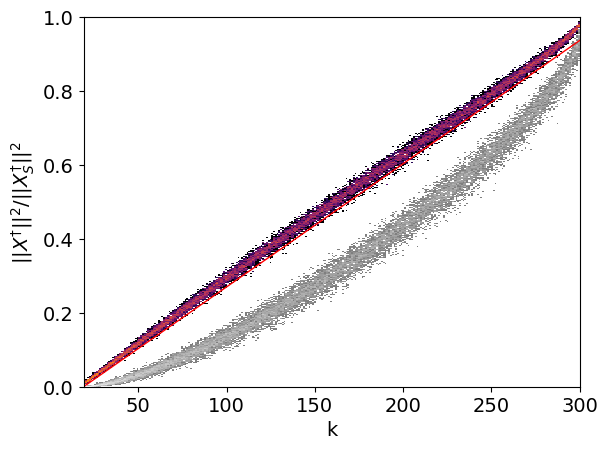

In [87]:
points = pd.read_csv(OUT_PATH + "greedy_removal_2_100/points.csv")
bound = pd.read_csv(OUT_PATH + "greedy_removal_2_100/bound.csv")

points_random = pd.read_csv(OUT_PATH + "random_100/points.csv")
#bound = pd.read_csv(OUT_PATH + "random_100/bound.csv")

plot_results(points, points_random, bound)
plt.savefig('../out/images/greedy_removal_2_random_m20_n300_samples100.png', bbox_inches="tight", dpi=500)

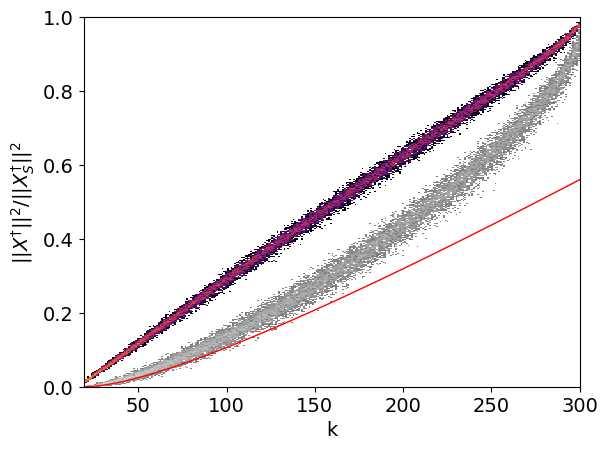

In [71]:
points = pd.read_csv(OUT_PATH + "greedy_selection_1_100/points.csv")
bound = pd.read_csv(OUT_PATH + "greedy_selection_1_100/bound.csv")

points_random = pd.read_csv(OUT_PATH + "random_100/points.csv")
#bound = pd.read_csv(OUT_PATH + "random_100/bound.csv")

plot_results(points, points_random, bound)
plt.savefig('../out/images/greedy_selection_1_random_m20_n300_samples100.png', bbox_inches="tight")